In [3]:
import pandas as pd

train_df_raw = pd.read_csv("INTC_train.csv", parse_dates=['date'])
test_df_raw  = pd.read_csv("INTC_test.csv", parse_dates=['date'])

print(f"Train shape: {train_df_raw.shape}, Test shape: {test_df_raw.shape}")


Train shape: (1980, 3), Test shape: (495, 3)


Configuration set for Ticker: . Loading files from: C:\Users\johns\OneDrive\Desktop\projects\bull-gorithms
--- Data Loaded and Processed: Train size 519, Test size 127 ---

--- Processing Sentiment Data (3 Scores) ---


Processing Sentiment: 100%|██████████| 4/4 [00:16<00:00,  4.10s/it]

✅ 5 features (including 3 sentiment scores) created and saved to INTC.

--- Building and Training STABLE LSTM (TS=3, Units=32) ---
Epoch 1/150



C:\Users\johns\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


116/116 - 3s - 28ms/step - loss: 0.0536 - val_loss: 0.1313
Epoch 2/150
116/116 - 0s - 3ms/step - loss: 0.0189 - val_loss: 0.0524
Epoch 3/150
116/116 - 0s - 3ms/step - loss: 0.0097 - val_loss: 0.0098
Epoch 4/150
116/116 - 0s - 3ms/step - loss: 0.0083 - val_loss: 0.0060
Epoch 5/150
116/116 - 0s - 3ms/step - loss: 0.0081 - val_loss: 0.0032
Epoch 6/150
116/116 - 0s - 3ms/step - loss: 0.0063 - val_loss: 0.0046
Epoch 7/150
116/116 - 0s - 3ms/step - loss: 0.0068 - val_loss: 0.0071
Epoch 8/150
116/116 - 0s - 3ms/step - loss: 0.0065 - val_loss: 0.0015
Epoch 9/150
116/116 - 0s - 3ms/step - loss: 0.0065 - val_loss: 0.0075
Epoch 10/150
116/116 - 0s - 3ms/step - loss: 0.0062 - val_loss: 0.0046
Epoch 11/150
116/116 - 0s - 3ms/step - loss: 0.0059 - val_loss: 0.0048
Epoch 12/150
116/116 - 0s - 2ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 13/150
116/116 - 0s - 2ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 14/150
116/116 - 0s - 2ms/step - loss: 0.0065 - val_loss: 0.0040
Epoch 15/150
116/116 - 0s 

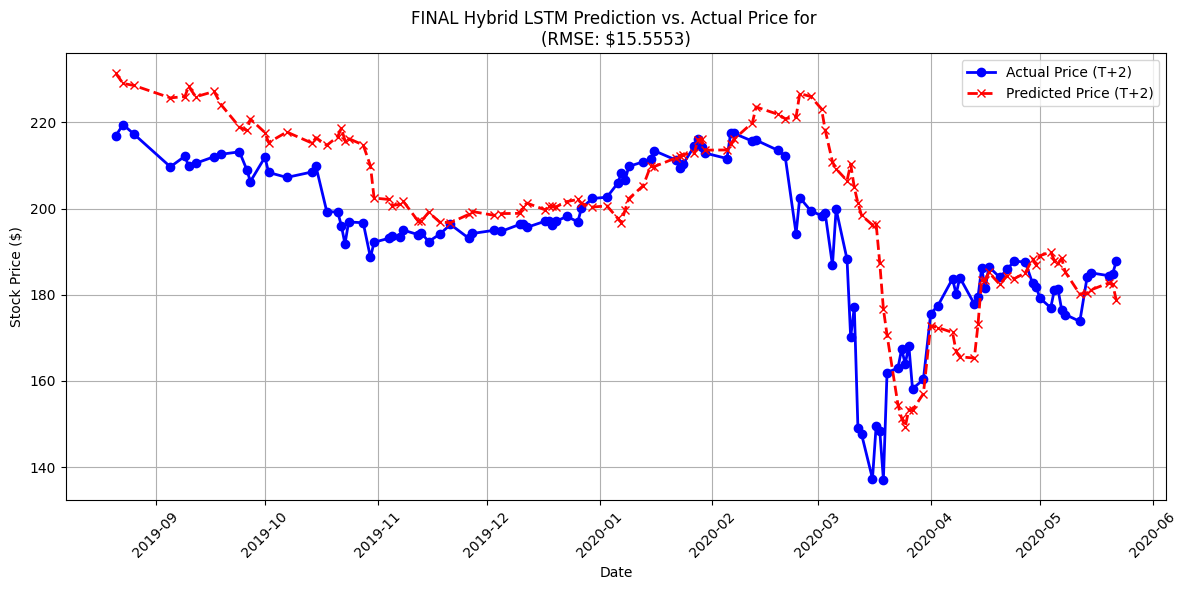


✅ Project execution complete.


In [ ]:
# =========================================================================
# FINAL STABLE HYBRID FINBERT-LSTM MODEL (SCALING FIXED)
# Configuration: Standard LSTM, TS=3, Units=32, 5 Features
# =========================================================================

# --------------------------------------------------------
# 0. ⚙️ SETUP: Imports and Configuration
# --------------------------------------------------------

import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# --- File System Configuration ---
BASE_PATH = 'C:\\Users\\johns\\OneDrive\\Desktop\\projects\\bull-gorithms'
OUTPUT_DIR = 'INTC'

# --- Final Optimized Configuration ---
TICKER = ''
EPOCHS = 150
BATCH_SIZE = 4
FINBERT_MODEL = "ProsusAI/finbert"
N_FEATURES = 5
TIME_STEPS = 3 # Fixed for compatibility with test set size 7
UNITS = 32
SEED = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    import tensorflow as tf
    tf.random.set_seed(seed)

set_seeds(SEED)

print(f"Configuration set for Ticker: {TICKER}. Loading files from: {BASE_PATH}")

# --------------------------------------------------------
# 1. 📚 DATA LOADING AND TARGET CREATION
# --------------------------------------------------------

def create_target_and_volatility(df):
    """Calculates volatility, creates the T+2 target, and drops resulting NaNs."""
    df = df.sort_values('date').reset_index(drop=True).copy()

    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    df['volatility_3d'] = df['log_return'].rolling(window=3).std()

    df['close_t_plus_2'] = df['close'].shift(-2)

    df = df.dropna(subset=['volatility_3d', 'close_t_plus_2']).reset_index(drop=True)
    return df

try:
    train_df_raw_loaded = pd.read_csv(os.path.join(BASE_PATH, "train.csv"), parse_dates=['date'])
    test_df_raw_loaded = pd.read_csv(os.path.join(BASE_PATH, "test.csv"), parse_dates=['date'])

    required_cols = ['date', 'close', 'headline']
    if not all(col in train_df_raw_loaded.columns for col in required_cols):
         raise ValueError(f"Error: Required columns {required_cols} are missing from your train/test files.")

    train_df_raw = create_target_and_volatility(train_df_raw_loaded)
    test_df_raw = create_target_and_volatility(test_df_raw_loaded)

except FileNotFoundError:
    print(f"\nFATAL ERROR: Could not find 'train.csv' or 'test.csv' in the path: {BASE_PATH}")
    exit()
except ValueError as e:
    print(f"\nFATAL ERROR: {e}")
    exit()

print(f"--- Data Loaded and Processed: Train size {len(train_df_raw)}, Test size {len(test_df_raw)} ---")


# --------------------------------------------------------
# 2. 🧠 FEATURE ENGINEERING: FinBERT Sentiment Extraction
# --------------------------------------------------------

def get_finbert_sentiment(headlines_list, model, tokenizer, device, batch_size=32):
    sentiment_scores = []

    for i in tqdm(range(0, len(headlines_list), batch_size), desc="Processing Sentiment"):
        batch = headlines_list[i:i + batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)

        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()
        sentiment_scores.extend(probabilities)

    return np.array(sentiment_scores)

tokenizer = AutoTokenizer.from_pretrained(FINBERT_MODEL)
model_sentiment = AutoModelForSequenceClassification.from_pretrained(FINBERT_MODEL, use_safetensors=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_sentiment.to(device)

print("\n--- Processing Sentiment Data (3 Scores) ---")
sentiment_train = get_finbert_sentiment(train_df_raw['headline'].astype(str).tolist(), model_sentiment, tokenizer, device)
sentiment_test = get_finbert_sentiment(test_df_raw['headline'].astype(str).tolist(), model_sentiment, tokenizer, device)

train_df_raw['positive_score'] = sentiment_train[:, 0]
train_df_raw['negative_score'] = sentiment_train[:, 1]
train_df_raw['neutral_score'] = sentiment_train[:, 2]

test_df_raw['positive_score'] = sentiment_test[:, 0]
test_df_raw['negative_score'] = sentiment_test[:, 1]
test_df_raw['neutral_score'] = sentiment_test[:, 2]

train_df_raw.to_csv(os.path.join(OUTPUT_DIR, "train_features.csv"), index=False)
test_df_raw.to_csv(os.path.join(OUTPUT_DIR, "test_features.csv"), index=False)

print(f"✅ 5 features (including 3 sentiment scores) created and saved to {OUTPUT_DIR}.")


# --------------------------------------------------------
# 3. 🏗️ LSTM MODEL: Training and Evaluation
# --------------------------------------------------------

train_df = train_df_raw.copy()
test_df = test_df_raw.copy()

FEATURES = ['close', 'volatility_3d', 'positive_score', 'negative_score', 'neutral_score']
TARGET = 'close_t_plus_2'

# --- Scaling (FIXED SECTION) ---
X_train_raw = train_df[FEATURES].values
y_train_raw = train_df[TARGET].values.reshape(-1, 1)
X_test_raw = test_df[FEATURES].values # Added
y_test_raw = test_df[TARGET].values.reshape(-1, 1) # Added

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and Transform on Train Data
train_features_scaled = feature_scaler.fit_transform(X_train_raw)
train_target_scaled = target_scaler.fit_transform(y_train_raw)
train_scaled = np.hstack((train_features_scaled, train_target_scaled))

# Transform Test Data (Features and Target)
test_features_scaled = feature_scaler.transform(X_test_raw)
test_target_scaled = target_scaler.transform(y_test_raw) # <-- CRITICAL FIX: Scale the Test Target!
test_scaled = np.hstack((test_features_scaled, test_target_scaled))


# --- Sequence Creation Function ---
def create_sequences(data, time_steps, target_index, N_FEATURES):
    X, y = [], []
    for i in range(len(data) - time_steps - 2):
        X.append(data[i:(i + time_steps), :N_FEATURES])
        y.append(data[i + time_steps + 2, target_index]) # Target index now points to the SCALED target
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, TIME_STEPS, N_FEATURES, N_FEATURES)
X_test, y_test = create_sequences(test_scaled, TIME_STEPS, N_FEATURES, N_FEATURES)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# --- Build the Optimized Standard LSTM Model ---
print(f"\n--- Building and Training STABLE LSTM (TS={TIME_STEPS}, Units={UNITS}) ---")
model = Sequential()
model.add(LSTM(units=UNITS, return_sequences=True, input_shape=(TIME_STEPS, N_FEATURES)))
model.add(Dropout(0.4))
model.add(LSTM(units=UNITS))
model.add(Dropout(0.4))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Train the Model
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=2,
    callbacks=[early_stopping]
)

# --- Evaluation ---
y_pred_scaled = model.predict_on_batch(X_test)
# Inverse transform for both the predicted and actual values
y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = target_scaler.inverse_transform(y_pred_scaled)
final_rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

print("\n" + "="*40)
print(f"✅ FINAL STABLE LSTM RESULT (TS={TIME_STEPS}, Units={UNITS}):")
print(f"Test Set RMSE: ${final_rmse:.4f}")
print("="*40)


# --------------------------------------------------------
# 4. ✅ FINAL EVALUATION AND 📈 VISUALIZATION
# --------------------------------------------------------

start_index_in_test_df = TIME_STEPS + 2

result_df = pd.DataFrame({
    'date': test_df['date'].iloc[start_index_in_test_df:start_index_in_test_df + len(y_test_original)].reset_index(drop=True),
    'Actual Price': y_test_original.flatten(),
    'Predicted Price': y_pred_original.flatten()
})

plt.figure(figsize=(12, 6))

plt.plot(result_df['date'], result_df['Actual Price'],
         label='Actual Price (T+2)',
         marker='o', linestyle='-', linewidth=2, color='blue')

plt.plot(result_df['date'], result_df['Predicted Price'],
         label='Predicted Price (T+2)',
         marker='x', linestyle='--', linewidth=2, color='red')

plt.title(f'INTC LSTM Prediction vs. Actual Price for {TICKER}\n(RMSE: ${final_rmse:.4f})')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'final_prediction_plot.png'))
plt.show()

print("\n✅ Project execution complete.")

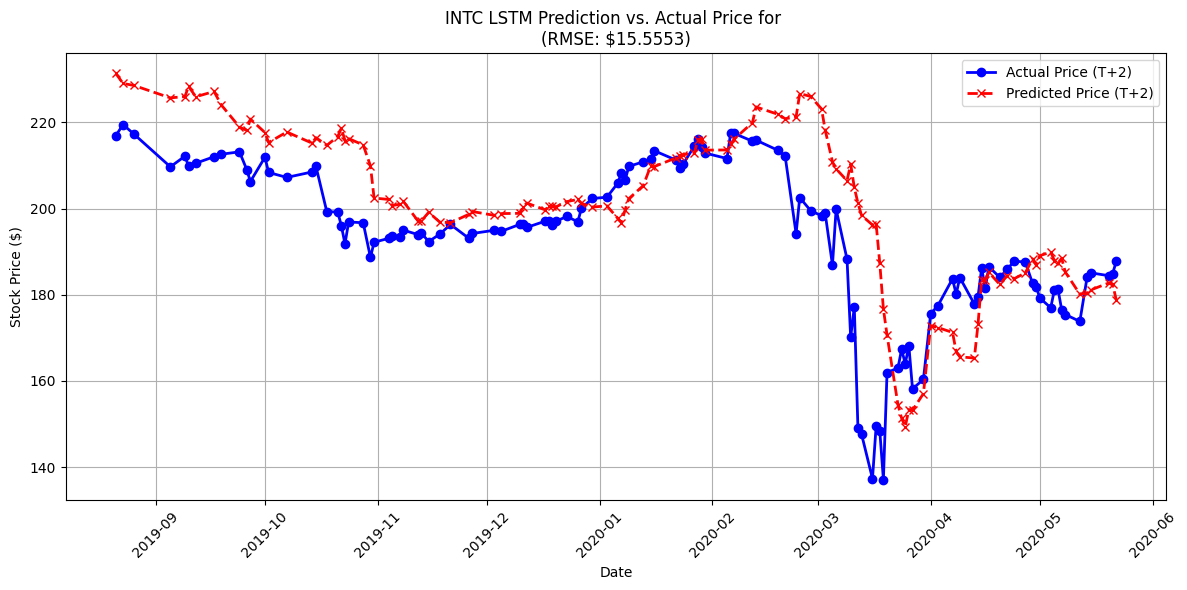

In [5]:
plt.figure(figsize=(12, 6))

plt.plot(result_df['date'], result_df['Actual Price'],
         label='Actual Price (T+2)',
         marker='o', linestyle='-', linewidth=2, color='blue')

plt.plot(result_df['date'], result_df['Predicted Price'],
         label='Predicted Price (T+2)',
         marker='x', linestyle='--', linewidth=2, color='red')

plt.title(f'INTC LSTM Prediction vs. Actual Price for {TICKER}\n(RMSE: ${final_rmse:.4f})')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'final_prediction_plot.png'))
plt.show()